# Ricky's Final Project - Part 4

## Pokedex Upgrade - Predicting the Legendary Status of Unknown Pokemon

### **Table of Contents**


**1) Problem and Hypothesis**
    * Problem Statement
    * Why machine learning?

**2) Dataset**
    * Data Dictionary
    * Feature Engineering
    
**3) Model Insights**
    * Importing Data
    * Feature Engineering
    * Exploritory Data Analysis
 
**4) Modeling Approach**
    * Random Forest - Feature Importance
    * Random Forest - Highest Importance Features
    * Random Forest - Only Physical Features
    * Logistic Regression

**5) Summary**
    * Results
    * Model Learning Curve
    * Key Take Aways

## ** 1) Problem and Hypothesis**

**Problem Statement**

Ever since 1996, thousands of young aspiring Pokemon masters leave their homes in an effort to "catch em all" with nothing more than the clothes on their back and a Pokedex. However, as time passes there seems to be an ever growing number of species. It can be daunting to encounter an unknown species for the first time. This project explores using predictive models to help a Pokedex classify unknown Pokemon as a 'Legendary' type based on previously discovered characteristics.

**How does this tie into machine learning?**

There are a few machine learning methods that can be used on this data set. To predict if a Pokemon is a legendary type we can convert a boolean feature and run a random forest or logistic regression. Both will require feature selection methods to reduce the number of variables that come into play. 

## **2) Data Set**


**Data Dictionary**

The origional data set includes 21 variables for each of the 721 Pokemon. Consisting of attribute types, battle statistics, gender, body characteristics and so on. The data types are made up of categorical strings, booleans, integers and floats.

* Number = Pokémon ID in the Pokédex (integer)
* Name = Name of the Pokémon (string)
* Type_1 = Primary type (string)
* Type_2 = Second type, in case the Pokémon has it (string)
* Total = Sum of all the base stats (Health Points, Attack, Defense, Special Attack, Special Defense, and Speed) (integer)
* HP = Base Health Points (integer)
* Attack = Base Attack (integer)
* Defense = Base Defense (integer)
* Sp_Atk = Base Special Attack (integer)
* Sp_Def = Base Special Defense (integer)
* Speed = Base Speed (integer)
* Generation = Number of the generation when the Pokémon was introduced (integer)
* isLegendary = Indicates whether the Pokémon is Legendary or not (boolean)
* Color = Color of the Pokémon according to the Pokédex (string)
* hasGender = Indicates if the Pokémon can be classified as female or male (boolean)
* Pr_male = In case the Pokémon has Gender, the probability of its being male (float)
* Egg_Group_1 = Egg Group of the Pokémon (string)
* Egg_Group_2 = Second Egg Group of the Pokémon, in case it has two (string)
* hasMegaEvolution = Indicates whether the Pokémon is able to Mega-evolve or not (boolean)
* Height_m = Height of the Pokémon, in meters (float)
* Weight_kg = Weight of the Pokémon, in kilograms (float)
* Catch_Rate = Catch Rate (integer)
* Body_Style = Body Style of the Pokémon according to the Pokédex (string)

**Data Set Details**

The data set was compiled on kaggle.com -> https://www.kaggle.com/abcsds/pokemon using the below sources from the video games series:

* pokemon.com
* pokemondb
* bulbapedia


## 3) **Modeling Insight**

### **Importing and Cleaning**

In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

plt.style.use('ggplot')

In [86]:
poke_data = pd.read_csv(os.path.join('.', 'pokemon_stats_data.csv'), index_col = 0)

"""I chose to drop a few variables because they were either irrelevant or redundant such as 'Name' which I substituted with
their registration number."""

remove_redundant = ['Egg_Group_2','Generation','Name']
poke_data.drop(remove_redundant, axis = 1, inplace=True)
poke_data['Pr_Male'].fillna(value=0, inplace=True) # Was missing values

poke_data.head(1)

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,,
1,Grass,Poison,318,45,49,49,65,65,45,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped


### **Feature Engineering**

To run Random Forest I needed to clean up the data further. I created additional features using several methods.
    * Used Pandas' get dummies function within a for loop to perform one hot coding and drop the redundant variable
    * Created a function to identify blank space to make a binary column
    * Using Numpy to create additional columns that are the summation of others 

In [87]:
# Additional feature: Creating binary dummies for the below true/false features
features = ['hasGender', 'isLegendary', 'hasMegaEvolution']
for feature in features:
    poke_data = pd.concat([poke_data, (pd.get_dummies(poke_data[feature], prefix=feature, drop_first=True))], axis=1)
    poke_data.drop(feature, axis=1, inplace=True)
    

# Additional feature: to use for modeling such as if Pokemon has a second categorical
def has_2nd_type(text_in):
    try:
        if ' ' in text_in:
            return 0
        else:
            return 1
    except: 
        return 0
        
poke_data['2nd_Type'] = poke_data['Type_2'].map(has_2nd_type)
del poke_data['Type_2']

# Additional features: Sum of their offensive and defensive stats
poke_data['Offensive_Stats'] = poke_data['Attack'] + poke_data['Sp_Atk'] + poke_data['Speed']
poke_data['Defensive_Stats'] = poke_data['HP'] + poke_data['Defense'] + poke_data['Sp_Def']

In [88]:
# Creating binary dummies for the below categorical features
# Created for a second dataset that has physical characteristics broken out

cat_feats = ['Body_Style','Type_1']
poke_data2 = poke_data.copy()

for cat_feat in cat_feats:
    poke_data2 = pd.concat([poke_data2, (pd.get_dummies(poke_data2[cat_feat], prefix=cat_feat, drop_first=True))], axis=1)
    poke_data2.drop(cat_feat, axis=1, inplace=True)
    
# Storing 3rd version for later use and as a backup
poke_data3 = poke_data2.copy()

## ** High Level EDA **

There is a fairly strong positive correlation between Total stats and isLegendary_True (.48), this makes sense as a rarer pokemon would have more strength. Additionally, Catch_Rate and hasGender_True is highly correlated. As it turns out 87% of Legendary Pokemon don't have a gender. Which aligns with why it shares a high negative correlation with isLegendary_True (-.65). To further drive home the point it looks like pokemon with no gender have a lower catch rate; meaning that it is more difficult to catch a pokemon without a sex implying that they may be legendary.

In [89]:
# Getting a feel for all the remaining features, data types and observation counts. We no longer have missing data.
poke_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 1 to 721
Data columns (total 21 columns):
Type_1                   721 non-null object
Total                    721 non-null int64
HP                       721 non-null int64
Attack                   721 non-null int64
Defense                  721 non-null int64
Sp_Atk                   721 non-null int64
Sp_Def                   721 non-null int64
Speed                    721 non-null int64
Color                    721 non-null object
Pr_Male                  721 non-null float64
Egg_Group_1              721 non-null object
Height_m                 721 non-null float64
Weight_kg                721 non-null float64
Catch_Rate               721 non-null int64
Body_Style               721 non-null object
hasGender_True           721 non-null float64
isLegendary_True         721 non-null float64
hasMegaEvolution_True    721 non-null float64
2nd_Type                 721 non-null int64
Offensive_Stats          721 non-null int64

In [90]:
# Examining the distribution of the data set
poke_data.describe()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Pr_Male,Height_m,Weight_kg,Catch_Rate,hasGender_True,isLegendary_True,hasMegaEvolution_True,2nd_Type,Offensive_Stats,Defensive_Stats
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,417.945908,68.380028,75.013870,70.808599,68.737864,69.291262,65.714286,0.494279,1.144979,56.773370,100.246879,0.893204,0.063800,0.063800,0.485437,209.466019,208.479889
std,109.663671,25.848272,28.984475,29.296558,28.788005,27.015860,27.277920,0.254878,1.044369,89.095667,76.573513,0.309068,0.244566,0.244566,0.500135,64.791947,62.402857
min,180.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000,0.100000,0.100000,3.000000,0.000000,0.000000,0.000000,0.000000,25.000000,70.000000
25%,320.000000,50.000000,53.000000,50.000000,45.000000,50.000000,45.000000,0.500000,0.610000,9.400000,45.000000,1.000000,0.000000,0.000000,0.000000,160.000000,160.000000
50%,424.000000,65.000000,74.000000,65.000000,65.000000,65.000000,65.000000,0.500000,0.990000,28.000000,65.000000,1.000000,0.000000,0.000000,0.000000,205.000000,205.000000
75%,499.000000,80.000000,95.000000,85.000000,90.000000,85.000000,85.000000,0.500000,1.400000,61.000000,180.000000,1.000000,0.000000,0.000000,1.000000,255.000000,250.000000
max,720.000000,255.000000,165.000000,230.000000,154.000000,230.000000,160.000000,1.000000,14.500000,950.000000,255.000000,1.000000,1.000000,1.000000,1.000000,450.000000,480.000000


In [91]:
# Examining correlation between isLegendary_True feature with all others. Total, Catch Rate and hasGender_True have high
# correlations

poke_data.corr().iloc[:,12]

Total                    0.481837
HP                       0.258926
Attack                   0.302786
Defense                  0.274446
Sp_Atk                   0.409739
Sp_Def                   0.360215
Speed                    0.286082
Pr_Male                 -0.406338
Height_m                 0.326323
Weight_kg                0.425219
Catch_Rate              -0.319302
hasGender_True          -0.644714
isLegendary_True         1.000000
hasMegaEvolution_True    0.047955
2nd_Type                 0.053026
Offensive_Stats          0.437946
Defensive_Stats          0.392043
Name: isLegendary_True, dtype: float64

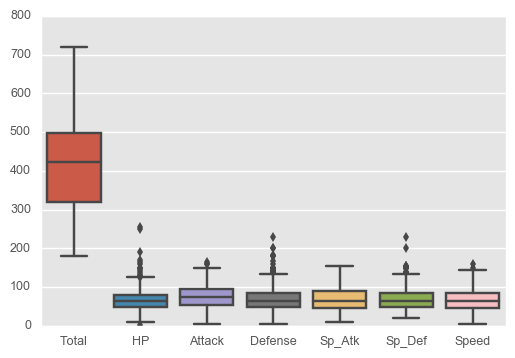

In [92]:
# Exploring individual battle stats using boxplots to examine for any outliers
# We can see that 'Total' stats has a wide range 
battle_stats = poke_data[['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']]
sns.boxplot(data=battle_stats);

In [93]:
# It appears the average Total stats of a legendary is 200 points higher than a the average non-legendary which would make
# sense that Total and isLegendary_True are highly correlated.

legend_breakout_total = poke_data.groupby(poke_data['isLegendary_True'], sort=True)['Total'].mean()
print legend_breakout_total

isLegendary_True
0.0    404.161481
1.0    620.217391
Name: Total, dtype: float64


87% of Legendary Pokemon don't have a gender. Which aligns with why it shares a high negative correlation with isLegendary_True (-.65). To further drive home the point it looks like pokemon with no gender have a lower catch rate; meaning that it is more difficult to a pokemon without a sex. 

In [94]:
# Displays the percent of Pokemon that have a Gender broken out by Legendary vs. Non-Legendary
legend_breakout_hasgender = poke_data.groupby(poke_data['isLegendary_True'], sort=True)['hasGender_True'].mean()
print legend_breakout_hasgender

isLegendary_True
0.0    0.945185
1.0    0.130435
Name: hasGender_True, dtype: float64


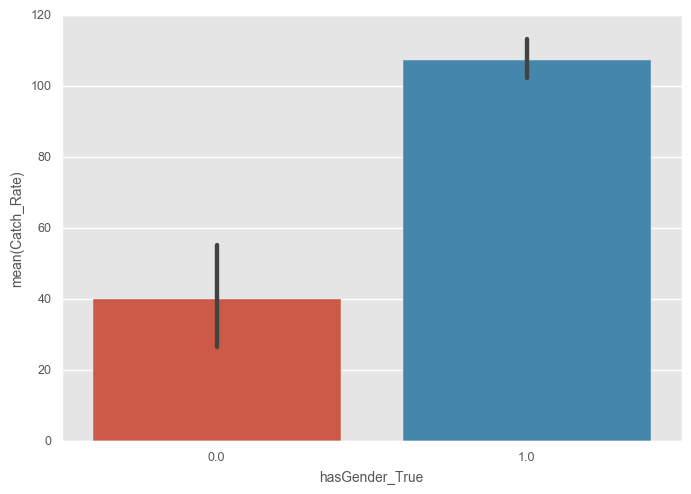

In [95]:
# A Pokemon without a gender on average has a lower likeihood of being caught. 
sns.set_context("notebook", font_scale=.90)
sns.barplot(x='hasGender_True', y='Catch_Rate', data=poke_data)

##  **4) Modeling Approach**

I decided to use a Random Forest for modeling and feature selection purposes. Having a smaller number of observations and a high count of features, I wanted to protect my model from overfitting. To ensure my data was proportionate in my testing groups I stratified my training and testing splits. 

Initially, I ran the model using the top scoring features and had great results. However, having battle stats in the equation seemed a bit unrealistic in the sense that how could a device measure the strength of a creature it has never before seen. Therefore, I decided to rerun my random forest using solely characteristics that can be determined physically.

Finally, to be better able to convey my findings to the Poke-community I used the same test train split from the phyiscal features random forest to run a logistic regression model. It would be easier to to explain in the sense that I can directly associate a coefficient to each feature rather than a black box using a random forest. Additionally, for the Pokedex to work effectively it would need to be able to run the model much faster than your a random forest could.

** Using Random Forest for Feature Selection **

Without creating a test/train split I imported the Random Forest Classifer and ran a feature importance test to give me a gauge of my most important features. It is no shock that Total stats and Catch Rate were at the top of the list making up ~ 45%. 

In [96]:
# No need to make test train split just yet. 
X_feat_test = poke_data2
y_feat_test = poke_data2['isLegendary_True']

remove = ['isLegendary_True', 'Color', 'Egg_Group_1']
X_feat_test.drop(remove, axis = 1, inplace=True)


In [97]:
# Call the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X_feat_test, y_feat_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [98]:
# Run Feature_Importance from Random Forest
features = X_feat_test.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

important_feat = features_df.head(50)
important_feat

# It appears that both Type and Body Type doesn't play a big role in regards to predicting a legendary classification. This
# aligns with what I learn in earlier EDA. I will remove those from my random forest to help save time when running.

,Features,Importance Score
0,Total,0.254231
10,Catch_Rate,0.133057
11,hasGender_True,0.090967
8,Height_m,0.085301
7,Pr_Male,0.067403
9,Weight_kg,0.049027
4,Sp_Atk,0.046448
2,Attack,0.041352
15,Defensive_Stats,0.040698
6,Speed,0.035605


** RANDOM FOREST - Using Highest Importance Features**

Seeing that Type and Body Style weren't all strong predicitors I chose to exclude them from this first round of Random Forest Testing. 

In [99]:
X = poke_data
y = poke_data['isLegendary_True']
remove = ['isLegendary_True', 'Body_Style', 'Color', 'Egg_Group_1', 'Type_1']
X.drop(remove, axis = 1, inplace=True)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

important_feat = features_df.head(100)
important_feat

,Features,Importance Score
0,Total,0.282662
10,Catch_Rate,0.208183
14,Offensive_Stats,0.105038
7,Pr_Male,0.078745
8,Height_m,0.077587
11,hasGender_True,0.068073
9,Weight_kg,0.035399
1,HP,0.031315
2,Attack,0.027628
4,Sp_Atk,0.022796


**Null Accuracy** - Assuming I guessed Non-Legendary for each would give me ~93% accuracy.

In [100]:
# Null accuracy.....How do you find the null f1 Score
1-y.mean()

0.9361997226074896

In [101]:
# Create a test and train split, making sure to stratify along the dependent variable. Making sure that I had a proportionate 
# sampling in my test set as to the overall data set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [102]:
# Used 10 splits, setting aside 30% for the testing, and I left random_state=1 to avoid constantly changing variables.

from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)

In [103]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
# transform our training features
X_train_std = stdsc.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = stdsc.transform(X_test)

In [104]:
# Used grid search to fine tune my model towards an f1 score. Finding the balance between Recall and Precision
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier()        

params = {'n_estimators': [10,20,30,40,50], 'max_depth': range(3,5), 'max_features': range(5,10)}
clf = GridSearchCV(rf_model, params, cv=cv, scoring='f1_macro')
output = clf.fit(X_train, y_train)

In [105]:
best_rf = clf.best_estimator_

print clf.best_params_
print clf.best_score_
print best_rf

{'max_features': 7, 'n_estimators': 40, 'max_depth': 3}
0.933505664574
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


**Cross Validation Scores** 

Average Cross Val Accuracy Score: .98

In [106]:
# Accuracy is higher than just guessing which is a sign.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X_train_std, y_train, cv=10, scoring='accuracy')
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV Accuracy [ 1.          0.96363636  0.96363636  1.          0.98148148  1.          1.
  0.98113208  0.98113208  1.        ], Average Accuracy 0.98710183597


Average Cross Val F1 Score: .92

In [107]:
scores_f1 = cross_val_score(best_rf, X_train_std, y_train, cv=10, scoring='f1_macro')
print('CV F1 Score {}, Average F1 Score {}'.format(scores_f1, scores_f1.mean()))

CV F1 Score [ 1.          0.89        0.82371795  1.          0.92362093  1.          1.
  0.92352092  0.92352092  1.        ], Average F1 Score 0.948438072928


**Prediction Scores**
    * Accuracy - .994
    * F1       - .96

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pred = output.predict(X_test)
score1 = accuracy_score(y_test,pred)
print score1
score2 = f1_score(y_test,pred)
print score2

0.994475138122
0.96


** RANDOM FOREST - Only Physical Features**

I realize it would be incredibly unrealistic for a device to somehow measure the strength and speed of a not yet discovered creature. Therefore, in this portion I have removed all features except for the physical traits. While in my EDA I found no strong correlation between legendary's and their attribute types; Gender, Height and Weight seemed to have fairly strong relationship, coupled with the more common Body Styles for Legendary's might be enough to help us make a prediction.

In [109]:
# Stripping away all attributes that aren't physical

remove_stats = ['Total','HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','2nd_Type','Offensive_Stats','Defensive_Stats',
                'hasMegaEvolution_True','Catch_Rate','Pr_Male','Egg_Group_1','Color']
poke_data3.drop(remove_stats, axis=1, inplace=True)
poke_data3.head(1)

,Height_m,Weight_kg,hasGender_True,isLegendary_True,Body_Style_bipedal_tailless,Body_Style_four_wings,Body_Style_head_arms,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings,Body_Style_with_fins,Type_1_Dark,Type_1_Dragon,Type_1_Electric,Type_1_Fairy,Type_1_Fighting,Type_1_Fire,Type_1_Flying,Type_1_Ghost,Type_1_Grass,Type_1_Ground,Type_1_Ice,Type_1_Normal,Type_1_Poison,Type_1_Psychic,Type_1_Rock,Type_1_Steel,Type_1_Water
Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.71,6.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
X2 = poke_data3
y2 = poke_data3['isLegendary_True']
remove2 = ['isLegendary_True']
X2.drop(remove2, axis = 1, inplace=True)

from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators = 20)
model.fit(X2, y2)

features = X2.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

important_feat = features_df.head(100)
important_feat

,Features,Importance Score
2,hasGender_True,0.310012
0,Height_m,0.221563
1,Weight_kg,0.195898
5,Body_Style_head_arms,0.028876
14,Body_Style_two_wings,0.025441
31,Type_1_Steel,0.019199
11,Body_Style_quadruped,0.019019
29,Type_1_Psychic,0.018611
8,Body_Style_head_only,0.016026
17,Type_1_Dragon,0.015987


In [111]:
important_feat2 = important_feat.iloc[0:-20]
features = important_feat2.iloc[:,0]

In [112]:
X2_features = X2[features]
X2_features.head()

,hasGender_True,Height_m,Weight_kg,Body_Style_head_arms,Body_Style_two_wings,Type_1_Steel,Body_Style_quadruped,Type_1_Psychic,Body_Style_head_only,Type_1_Dragon,Body_Style_bipedal_tailless,Type_1_Electric,Type_1_Ground
Number,,,,,,,,,,,,,
1,1.0,0.71,6.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.99,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.01,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.61,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.09,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2_features, y2, stratify=y2, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)

In [114]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
# transform our training features
X_train_std2 = stdsc.fit_transform(X_train2)
# transform the testing features in the same way
X_test_std2 = stdsc.transform(X_test2)

In [115]:
from sklearn.model_selection import GridSearchCV
rf_model2 = RandomForestClassifier()        

params = {'n_estimators': [80,90,100], 'max_depth': range(3,6), 'max_features': range(5,13)}
clf2 = GridSearchCV(rf_model2, params, cv=cv, scoring='f1_macro')
output2 = clf2.fit(X_train_std2, y_train2)

In [116]:
best_params = clf2.best_estimator_

print clf2.best_params_
print clf2.best_score_
print best_params

{'max_features': 7, 'n_estimators': 90, 'max_depth': 3}
0.854544335757
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


**Cross Validation Scores** 

Average Cross Val Accuracy Score: .97

In [117]:
scores_Acc_1 = cross_val_score(best_params, X_train_std2, y_train2, cv=10, scoring='accuracy')
print('CV Accuracy {}, Average Accuracy Score {}'.format(scores_Acc_1, scores_Acc_1.mean()))

CV Accuracy [ 0.96363636  0.94545455  0.98181818  0.98181818  0.96296296  0.98148148
  1.          0.96226415  0.96226415  0.96226415], Average Accuracy Score 0.970396417


Average Cross Val F1 Score: .85

In [118]:
scores_F1_1 = cross_val_score(best_params, X_train_std2, y_train2, cv=10, scoring='f1_macro')
print('CV F1 Score {}, Average F1 Score {}'.format(scores_F1_1, scores_F1_1.mean()))

CV F1 Score [ 0.82371795  0.82371795  0.92371706  0.92371706  0.89514563  0.89514563
  1.          0.82333333  0.74019608  0.74019608], Average F1 Score 0.858888676905


**Prediction Scores**
    * Accuracy - .98
    * F1       - .86

In [119]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pred2 = output2.predict(X_test_std2)
score3 = accuracy_score(y_test2,pred2)
print score3
score4 = f1_score(y_test2,pred2)
print score4

0.983425414365
0.857142857143


**Logistic Regression**

To be able to further explain my findings to the poke-community I decided to run a logistic regression so I would be able to find a direct coefficient for each variable and show which play a larger role in the model.

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression(penalty='l2', C=10)      

params2 = {'penalty': ['l1'], 'C': range(1,10), 'class_weight': [None, 'balanced']}
logit = GridSearchCV(logreg, params2, cv=cv, scoring='f1_macro')
output3 = logit.fit(X_train_std2, y_train2)

In [79]:
best_logit_param = logit.best_estimator_

print logit.best_params_
print logit.best_score_
print best_logit_param

{'penalty': 'l1', 'C': 1, 'class_weight': None}
0.818082006664
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [80]:
scores_log = cross_val_score(best_logit_param, X_train_std2, y_train2, cv=10, scoring='f1_macro')
print('CV F1 Score {}, Average F1 Score {}'.format(scores_log, scores_log.mean()))

CV F1 Score [ 0.82371795  0.73039216  0.92371706  0.73039216  0.7708628   0.74038462
  0.92352092  0.82333333  0.82333333  0.48543689], Average F1 Score 0.777509122142


**Prediction Scores**
    * Accuracy - .978
    * F1       - .8

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pred_log = output3.predict(X_test_std2)

score_Acc_2 = accuracy_score(y_test2,pred_log)
print score_Acc_2
score_F1_2 = f1_score(y_test2,pred_log)
print score_F1_2

0.977900552486
0.8


In [82]:
best_logit_param.coef_

array([[-1.30509967,  0.31808118,  0.3867575 ,  0.4367065 ,  0.74501692,
         0.77664725,  0.50662588,  0.37856076, -0.04087109, -0.20998001,
         0.        ,  0.        ,  0.32315647]])

In [83]:
# Clear coefficiencts of each physical feature
pd.DataFrame({'features': X2_features.columns, 'coefficients': best_logit_param.coef_[0], 'log_odds': np.exp(best_logit_param.coef_[0])})

,coefficients,features,log_odds
0,-1.305100,hasGender_True,0.271146
1,0.318081,Height_m,1.374488
2,0.386758,Weight_kg,1.472199
3,0.436706,Body_Style_head_arms,1.547602
4,0.745017,Body_Style_two_wings,2.106477
5,0.776647,Body_Style_quadruped,2.174171
6,0.506626,Type_1_Dragon,1.659682
7,0.378561,Body_Style_bipedal_tailless,1.460182
8,-0.040871,Type_1_Electric,0.959953
9,-0.209980,Type_1_Ground,0.810600


## **5) Summary **

**Results**

Working almost in the reverse order in which you would want to tune a model I actually saw decreasing performance in regards to Accuracy and F1 Score. However, my model is much closer to match the use case for the Pokedex. 

Using the null hypothesis (assuming all Pokemon are non legendary) I would be correct 93% of the time. Which means my accuracy would need to be higher than that benchmark. Additionally, I tuned each of my models towards a F1 score which is the mean of Recall (true positives out of the guesses) and Precision (true positives out of those that should have been positive).

1) Using all of the highest importance features : 
    
  **Prediction Scores**
        * Accuracy Score - .99
        * F1 Score       - .96
        
2) Using solely physical features:

  **Prediction Scores**
        * Accuracy Score - .98
        * F1 Score       - .86
        
3) Logistic Regression physical features:
    
  **Prediction Scores**
        * Accuracy Score - .978
        * F1 Score       - .8

**Learning Curve**

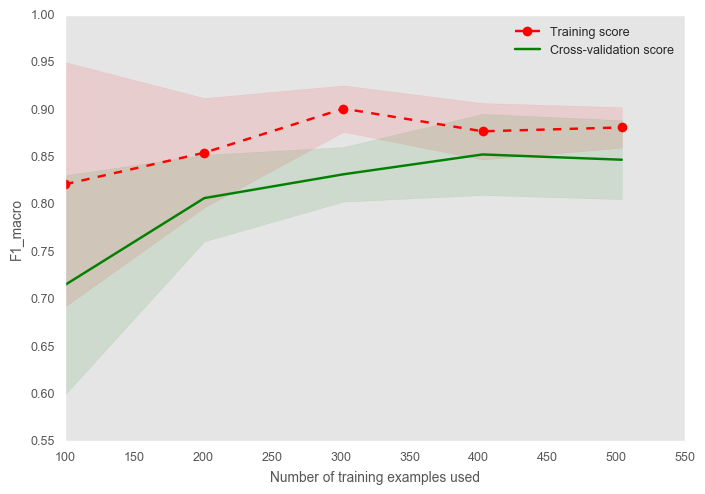

In [84]:
# Using a learning curve model we can see that there is a lift in score with the addition of new observations but it looks like 
# it begins to level off after a certain point 400 observat

from sk_modelcurves.learning_curve import draw_learning_curve

draw_learning_curve(best_logit_param, X2_features, y2, scoring='f1_macro', cv=cv);

**Key Take Aways**

Origionally I thought adding more species as observations would help strengthen my training scores for my logistic regressions. As it turns out after 400 training examples my cross validation score levels off. What might help revisiting is feature engineering. Creating a stronger indicator might help to build a better performing model.

In summary the final logistic regression model could be used in real time within the Pokedex but it could ue further tuning. With an accuracy of 98% and a F1 score of 80% (not exactly where I would like this measurement of accuracy to be). At the very least it would provide Pokemon trainers an additional resource to better ready themselves for the unknown world. 